In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [39]:
def clean_ts(df):
    return df[(df['author_timestamp'] > 1104600000) & (df['author_timestamp'] < 1487807212)]
df = clean_ts(pd.read_csv('linux_kernel_git_revlog.csv'))
df['author_dt'] = pd.to_datetime(df['author_timestamp'],unit='s')
df.head()

,author_timestamp,commit_hash,commit_utc_offset_hours,filename,n_additions,n_deletions,subject,author_id,author_dt
0,1487807211,f201ebd87652cf1519792f8662bb3f862c76aa33,-8,mm/z3fold.c,7,3,mm/z3fold.c: limit first_num to the actual ran...,0,2017-02-22 23:46:51
1,1487807208,083fb8edda0487d192e8c117f625563b920cf7a4,-8,include/linux/pagemap.h,0,1,mm: fix <linux/pagemap.h> stray kernel-doc not...,1,2017-02-22 23:46:48
2,1487807205,c87d1655c29500b459fb135258a93f8309ada9c7,-8,Documentation/ABI/obsolete/sysfs-block-zram,0,119,zram: remove obsolete sysfs attrs,2,2017-02-22 23:46:45
3,1487807205,c87d1655c29500b459fb135258a93f8309ada9c7,-8,Documentation/ABI/testing/sysfs-block-zram,8,92,zram: remove obsolete sysfs attrs,2,2017-02-22 23:46:45
4,1487807205,c87d1655c29500b459fb135258a93f8309ada9c7,-8,Documentation/blockdev/zram.txt,34,39,zram: remove obsolete sysfs attrs,2,2017-02-22 23:46:45


In [40]:
time_df = df.groupby(['author_timestamp', 'author_dt'])[['n_additions', 'n_deletions']].agg(np.sum).reset_index().sort_values('author_timestamp', ascending=True)
time_df['diff'] = time_df['n_additions'] - time_df['n_deletions']
time_df.head()

,author_timestamp,author_dt,n_additions,n_deletions,diff
0,1105046205,2005-01-06 21:16:45,18,5,13
1,1105535306,2005-01-12 13:08:26,153,60,93
2,1105537950,2005-01-12 13:52:30,21,10,11
3,1105614279,2005-01-13 11:04:39,4,7,-3
4,1105629989,2005-01-13 15:26:29,19,7,12


<AxesSubplot:title={'center':'lines of code added'}, xlabel='author_dt'>

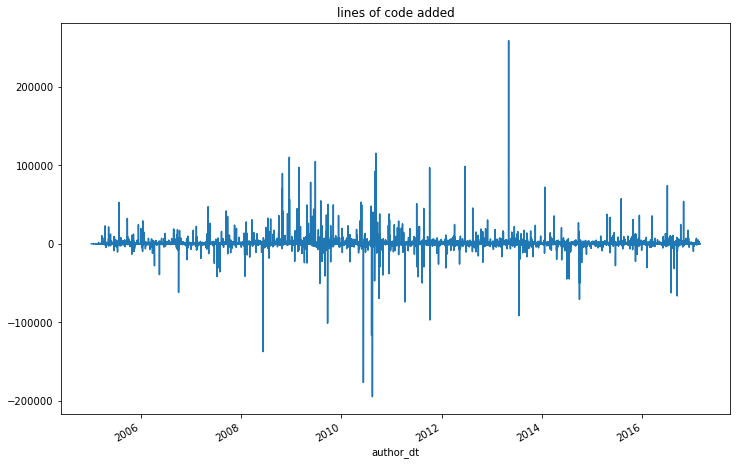

In [41]:
t = pd.Series(time_df['diff'].values, index=time_df['author_dt'])
t.plot(title='lines of code added', figsize=(12,8))

<AxesSubplot:title={'center':'number of commits on original time series'}, xlabel='author_dt'>

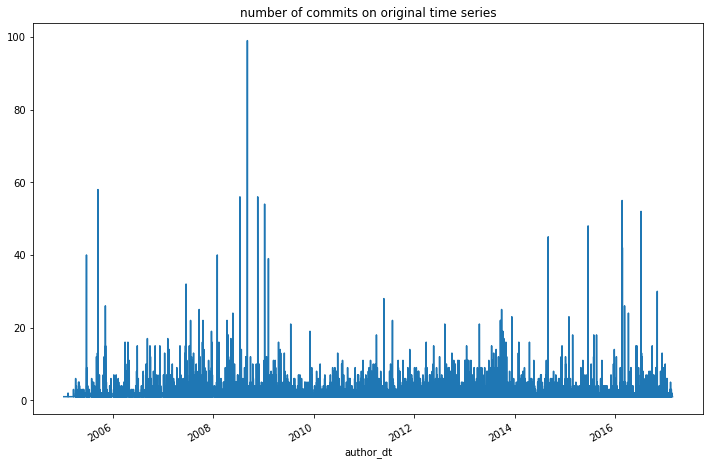

In [42]:
commits_over_time = df.groupby('author_dt')['commit_hash'].nunique().reset_index().sort_values('author_dt', ascending=True)
commits_series = pd.Series(commits_over_time['commit_hash'].values, index=commits_over_time['author_dt'])
commits_series.plot(title='number of commits on original time series', figsize=(12,8))

<AxesSubplot:title={'center':'number of commits on monthly resampled data'}, xlabel='author_dt'>

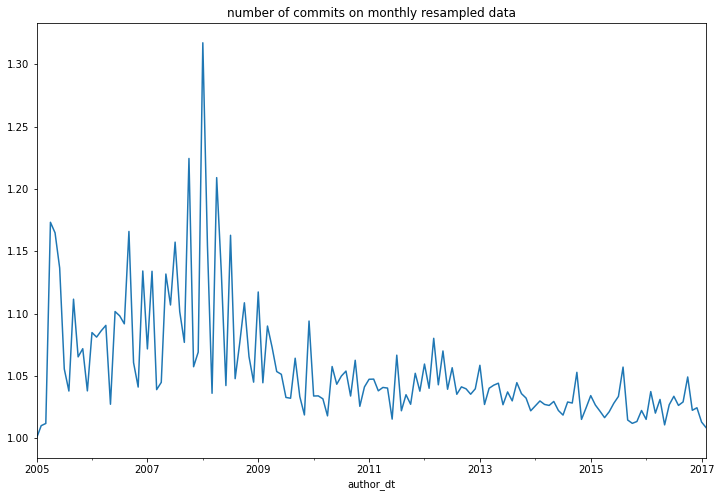

In [43]:
commits_series.resample('M').mean().plot(title='number of commits on monthly resampled data', figsize=(12,8))

<AxesSubplot:title={'center':'number files changed per commit'}, xlabel='author_dt'>

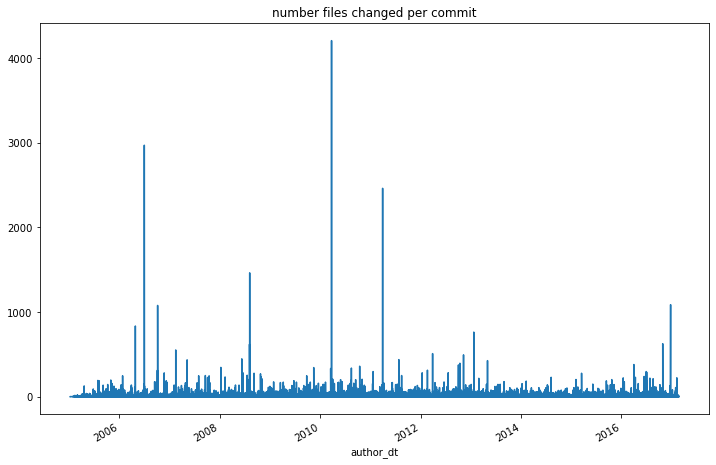

In [44]:
files_changed_per_commit = df.groupby(['author_dt', 'commit_hash'])['filename'].agg('count').reset_index().sort_values('author_dt', ascending=True)
files_changed_per_commit = pd.Series(files_changed_per_commit['filename'].values, index=files_changed_per_commit['author_dt'])
files_changed_per_commit.plot(title='number files changed per commit', figsize=(12,8))

Text(0.5, 0, 'number of changed files')

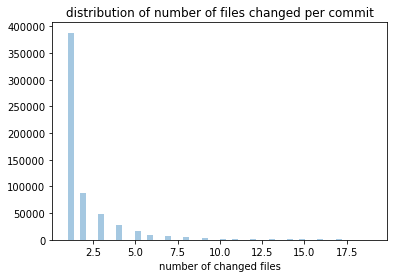

In [45]:
# trim distribution, there are a few heavy outliers in the data as we saw above 
n_files_changed_per_commit = df.groupby('commit_hash')['filename'].agg('count')
n_files_changed_per_commit = n_files_changed_per_commit[n_files_changed_per_commit < 20]
sns.distplot(n_files_changed_per_commit, kde=False)
plt.title('distribution of number of files changed per commit')
plt.xlabel('number of changed files')

<AxesSubplot:xlabel='n_additions', ylabel='Density'>

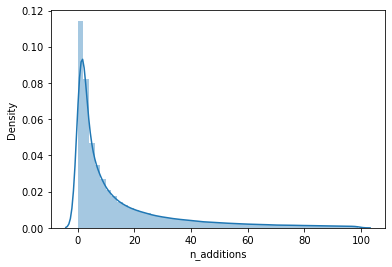

In [46]:
# trim distribution, there are a few heavy outliers in the data as we saw above 
additions_per_commit = df.groupby('commit_hash')['n_additions'].agg(np.sum)
additions_per_commit = additions_per_commit[additions_per_commit < 100]
sns.distplot(additions_per_commit)

<AxesSubplot:>

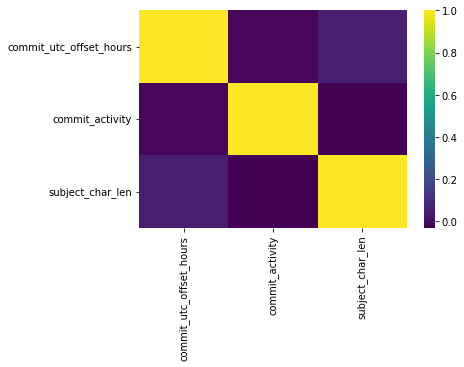

In [55]:
df['commit_activity'] = df['n_additions'] + df['n_deletions']
cmap = plt.get_cmap('viridis')
sns.heatmap(df[['commit_utc_offset_hours', 'commit_activity', 'subject_char_len']].corr(), cmap=cmap)